## モジュールの読み込み
> モジュールを追加する時はモジュール名のアルファベット順に追加してください

In [ ]:
import gc
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyperclip
import re
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

## サンプルデータの読み込み
> ここはいじっちゃダメ

In [ ]:
# サンプルデータを読み込む
data_path = '../../sample_data'
with open(f'{data_path}/dtype/dtype_str.txt') as f:
    col = f.read().split('\n')
dtype = {'dtype': {c:'str' for c in col}}
customer = pd.read_csv(f'{data_path}/csv/customer.csv', **dtype)
category = pd.read_csv(f'{data_path}/csv/category.csv', **dtype)
product = pd.read_csv(f'{data_path}/csv/product.csv', **dtype)
receipt = pd.read_csv(f'{data_path}/csv/receipt.csv', **dtype)
store = pd.read_csv(f'{data_path}/csv/store.csv', **dtype)
geocode = pd.read_csv(f'{data_path}/csv/geocode.csv', **dtype)

---
## データの読み込み
> 大きなデータを扱うときやスクリプトをシステムに組み込むときはオプションを手動で設定しておきたい

### 読み込む行数やカラム名を指定
> 横に長いデータを扱うときやデータの確認をするときに便利

In [ ]:
# nrows=0とするとカラム名が確認できる
display(pd.read_csv(f'{data_path}/csv/customer.csv', nrows=0))
# カラム名を指定して先頭5行だけ読み込み
usecols = ['customer_id', 'status_cd']
display(pd.read_csv(f'{data_path}/csv/customer.csv', usecols=usecols, nrows=5))

,customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd


,customer_id,status_cd
0,CS021313000114,0-00000000-0
1,CS037613000071,0-00000000-0
2,CS031415000172,D-20100325-C
3,CS028811000001,0-00000000-0
4,CS001215000145,6-20090929-2


### 型指定をして読み込む
> 返されたエラーによりデータの破損を検知できる  
> 数値範囲がわかっているのであればint32で読み込むとメモリ節約になる（※後述）  
> 型推論が実行されないため読み込みが高速化することがある

In [ ]:
dtype = {'dtype': 
            {
                'sales_ymd': 'int64',
                'sales_epoch': 'int64',
                'store_cd': 'object',
                'receipt_sub_no': 'int64',
                'customer_id': 'object',
                'product_cd': 'object',
                'quantity': 'int64',
                'amount': 'int64'
            }
}
encd = {'encoding': 'utf-8'}
kwds = {**dtype, **encd}

df = pd.read_csv(f'{data_path}/csv/receipt.csv', **kwds)
display(df.head(1))
df.info()

,sales_ymd,sales_epoch,store_cd,receipt_no,receipt_sub_no,customer_id,product_cd,quantity,amount
0,20181103,1541203200,S14006,112,1,CS006214000001,P070305012,1,158


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104681 entries, 0 to 104680
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   sales_ymd       104681 non-null  int64 
 1   sales_epoch     104681 non-null  int64 
 2   store_cd        104681 non-null  object
 3   receipt_no      104681 non-null  int64 
 4   receipt_sub_no  104681 non-null  int64 
 5   customer_id     104681 non-null  object
 6   product_cd      104681 non-null  object
 7   quantity        104681 non-null  int64 
 8   amount          104681 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 7.2+ MB


---
## メモリの節約
> ローカルPCでも大きなファイルを扱えたり、処理が早くなったりする

### int型の数値範囲

In [ ]:
def calc_int_range(bit):
    return int(2**bit/2)

def calc_total_length(bit):
    num_range = calc_int_range(bit)
    num_len = np.round(int(np.log10(num_range)),0)+1
    comma_cnt = (num_len-1)//3
    total_length = num_len + comma_cnt
    return total_length

for bit in [2**c for c in range(3,7)]:
    num_min = -calc_int_range(bit)
    num_max = -num_min-1
    max_len = calc_total_length(64)+1 # +1はマイナス符号の分
    print(f'int{bit:<2}: {num_min:>{max_len},} ~ +{num_max:<{max_len},}')

int8 :                       -128 ~ +127                       
int16:                    -32,768 ~ +32,767                    
int32:             -2,147,483,648 ~ +2,147,483,647             
int64: -9,223,372,036,854,775,808 ~ +9,223,372,036,854,775,807 


### データ型の変換によるメモリの節約

#### int32の活用
> int16は3万弱までしか扱えないが、int32は20億まで扱える

In [ ]:
# 100万行のDataFrameを作成。整数のみを含むカラムはデフォルではint64となる
df1 = pd.DataFrame(index=(r:=range(0, 1_000_000)), columns=['value'], data=r)
print(df1.info(), '\n')

# 値の範囲に問題なければint32にすることでメモリ使用量を半減できる
df1['value'] = df1['value'].astype('int32')
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   value   1000000 non-null  int64
dtypes: int64(1)
memory usage: 7.6 MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   value   1000000 non-null  int32
dtypes: int32(1)
memory usage: 3.8 MB
None


#### float型を縦に結合するとデータ型が書き変わる
> float32に変換してメモリを節約する方法もあるが、扱える桁数が少なくなり計算の精度が落ちる

In [ ]:
# float型を含むDataFrameを作成
df2 = pd.DataFrame(index=[0, 1], columns=['value'], data=[0.0, np.nan])

# df1にdf2を追加
df3 = df1.append(df2)

# データを確認。reset_indexをするとindexが連番になりメモリが節約できる
print(df3.info(), '\n')
print(df3.reset_index(drop=True).info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000002 entries, 0 to 1
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   value   1000001 non-null  float64
dtypes: float64(1)
memory usage: 15.3 MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000002 entries, 0 to 1000001
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   value   1000001 non-null  float64
dtypes: float64(1)
memory usage: 7.6 MB
None


#### メモリを節約しつつ欠損値を扱う


In [ ]:
df = df3.reset_index(drop=True).copy()

# 欠損値フラグを作成
df['NaN_flag'] = False
df['NaN_flag'] = df['NaN_flag'].mask(df['value'].isna(), True)
# bool型は2値なので非常に軽い。大きなデータを扱うときは安易に数値化しない方がよい

# 欠損値を置換し、int32型に変更
df.loc[pd.isnull(df['value']), 'value'] = -9999
df['value'] = df['value'].astype('int32')

# 欠損値をフラグ化して数値で補完することで7.6MBから4.8MBに節約できた
display(df.tail())
df.info()

,value,NaN_flag
999997,999997,False
999998,999998,False
999999,999999,False
1000000,0,False
1000001,-9999,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000002 entries, 0 to 1000001
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype
---  ------    --------------    -----
 0   value     1000002 non-null  int32
 1   NaN_flag  1000002 non-null  bool 
dtypes: bool(1), int32(1)
memory usage: 4.8 MB


### メモリの解放

DataFrameはメモリ効率がよくないので、不要となったら削除してメモリ解放するとよい  
環境により実行結果が変わるため、ここではコードを実行しない
```
del df
gc.collect()
```

---
## カラムの抽出
> 可読性とメンテナンス性を高めるテクニック

### カラム名に特定文字列を含まないものを抽出する（シンプルな実装）

In [ ]:
category[[c for c in category.columns if not 'small' in c]].head()

,category_major_cd,category_major_name,category_medium_cd,category_medium_name
0,04,惣菜,0401,御飯類
1,04,惣菜,0401,御飯類
2,04,惣菜,0402,佃煮類
3,04,惣菜,0402,佃煮類
4,04,惣菜,0402,佃煮類


### カラム名に特定文字列を含まないものを正規表現で抽出  
> コードは増えるが応用範囲は広い

In [ ]:
category[[c for c in category.columns if not re.match('.*small*.', c)]].head()

,category_major_cd,category_major_name,category_medium_cd,category_medium_name
0,04,惣菜,0401,御飯類
1,04,惣菜,0401,御飯類
2,04,惣菜,0402,佃煮類
3,04,惣菜,0402,佃煮類
4,04,惣菜,0402,佃煮類


---
## データ型のチェック
> 集計処理やデバッグ時に活用できる

### あるカラムにint以外が入っている行を表示する

In [ ]:
product[product['unit_price'].map(lambda x: not x.is_integer())]

,product_cd,category_major_cd,category_medium_cd,category_small_cd,unit_price,unit_cost
159,P040802007,04,0408,040802,NaN,NaN
196,P050103021,05,0501,050103,NaN,NaN
496,P050405009,05,0504,050405,NaN,NaN
1531,P060802026,06,0608,060802,NaN,NaN
2012,P070202092,07,0702,070202,NaN,NaN
6296,P080504027,08,0805,080504,NaN,NaN
7075,P090204185,09,0902,090204,NaN,NaN


### dtypeがobjectの列名のみ抽出する

In [ ]:
product.select_dtypes(include=object).columns.tolist()

['product_cd', 'category_major_cd', 'category_medium_cd', 'category_small_cd']

### dtypeがobjectでない列名のみ抽出する

In [ ]:
product.select_dtypes(exclude=object).columns.tolist()

['unit_price', 'unit_cost']

---
## データの結合
> ただのmergeやconcatではない結合方法をまとめる

### indicatorを使って片方にしかないレコードを明示する
> left_onlyとなるものは元データにしか存在せず、right_onlyとなるものは結合するデータにしか存在しない

In [ ]:
pd.merge(receipt, customer, on='customer_id', how='outer', indicator=True)\
    .query('_merge != "both"')[['sales_ymd', 'customer_id', '_merge']]

,sales_ymd,customer_id,_merge
48,20190205.0,ZZ000000000000,left_only
49,20170504.0,ZZ000000000000,left_only
50,20180329.0,ZZ000000000000,left_only
51,20170116.0,ZZ000000000000,left_only
52,20190621.0,ZZ000000000000,left_only
...,...,...,...
118341,NaN,CS042513000030,right_only
118342,NaN,CS002512000474,right_only
118343,NaN,CS012403000043,right_only
118344,NaN,CS033512000184,right_only


### 文字列の部分一致を条件にデータを結合する

In [ ]:
# 顧客データに近隣店舗のデータをマージする

# store_nameをリスト化
store_names = store['store_name'].to_list()
# 顧客の住所にstore_nameが含まれるかチェック
customer['store_name'] = customer['address'].map(lambda x: [elem for elem in store_names if elem.strip('店') in x])
# store_nameが含まれていたら0番目の要素を取得し、そうでなければNoneとする
customer['store_name'] = customer['store_name'].map(lambda x: x[0] if len(x) else None)
# store_nameをキーにして、顧客データに近隣店舗のデータをマージ
customer.merge(store[['store_name', 'longitude', 'latitude']], on='store_name', how='left').head()

,customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd,store_name,longitude,latitude
0,CS021313000114,大野 あや子,1,女性,1981-04-29,37,259-1113,神奈川県伊勢原市粟窪**********,S14021,20150905,0-00000000-0,伊勢原店,139.3129,35.40169
1,CS037613000071,六角 雅彦,9,不明,1952-04-01,66,136-0076,東京都江東区南砂**********,S13037,20150414,0-00000000-0,南砂店,139.8229,35.67066
2,CS031415000172,宇多田 貴美子,1,女性,1976-10-04,42,151-0053,東京都渋谷区代々木**********,S13031,20150529,D-20100325-C,None,NaN,NaN
3,CS028811000001,堀井 かおり,1,女性,1933-03-27,86,245-0016,神奈川県横浜市泉区和泉町**********,S14028,20160115,0-00000000-0,None,NaN,NaN
4,CS001215000145,田崎 美紀,1,女性,1995-03-29,24,144-0055,東京都大田区仲六郷**********,S13001,20170605,6-20090929-2,仲六郷店,139.7132,35.55135


### すごく早い全結合

In [ ]:
# 時系列データに欠損がある場合に有用
ymd = list(range(20230101, 20230104, 1))
store = ['small', 'large']
df1 = pd.DataFrame({'ymd': np.repeat(ymd, len(store)),
                   'store': store*len(ymd)})
df1

,ymd,store
0,20230101,small
1,20230101,large
2,20230102,small
3,20230102,large
4,20230103,small
5,20230103,large


### すごく早い全結合（3列以上）

In [ ]:
# 1列増やしたい場合は、ユニーク数の少ない列同士で全結合してからマージすると良い
store = ['small', 'large']
gender = ['male', 'female']
df2 = pd.DataFrame({'store': np.repeat(store, len(gender)),
                   'gender': gender*len(store)})
df1.merge(df2).sort_values(['ymd', 'store', 'gender'])

,ymd,store,gender
7,20230101,large,female
6,20230101,large,male
1,20230101,small,female
0,20230101,small,male
9,20230102,large,female
8,20230102,large,male
3,20230102,small,female
2,20230102,small,male
11,20230103,large,female
10,20230103,large,male


### 特定のデータにフラグを立てる

#### maskメソッドを使う方法
> 直感的に書けるが少し冗長な印象

In [ ]:
black_list = ['大野 あや子', '堀井 かおり']
df = customer.copy()

df['in_black_list'] = False
df['in_black_list'].mask(df['customer_name'].isin(black_list), True, inplace=True)
df.head()

,customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd,store_name,in_black_list
0,CS021313000114,大野 あや子,1,女性,1981-04-29,37,259-1113,神奈川県伊勢原市粟窪**********,S14021,20150905,0-00000000-0,伊勢原店,True
1,CS037613000071,六角 雅彦,9,不明,1952-04-01,66,136-0076,東京都江東区南砂**********,S13037,20150414,0-00000000-0,南砂店,False
2,CS031415000172,宇多田 貴美子,1,女性,1976-10-04,42,151-0053,東京都渋谷区代々木**********,S13031,20150529,D-20100325-C,None,False
3,CS028811000001,堀井 かおり,1,女性,1933-03-27,86,245-0016,神奈川県横浜市泉区和泉町**********,S14028,20160115,0-00000000-0,None,True
4,CS001215000145,田崎 美紀,1,女性,1995-03-29,24,144-0055,東京都大田区仲六郷**********,S13001,20170605,6-20090929-2,仲六郷店,False


#### 新たにDataFrameを作って結合させる方法
> black_listのテーブルを作って結合させるイメージ。コードではなくテーブルを管理すればよくなるのでメンテナンス性に優れる

In [ ]:
bl_df = pd.DataFrame(black_list, columns=['customer_name'])
bl_df['in_black_list'] = True
customer.merge(bl_df, how='left').head()

,customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd,store_name,in_black_list
0,CS021313000114,大野 あや子,1,女性,1981-04-29,37,259-1113,神奈川県伊勢原市粟窪**********,S14021,20150905,0-00000000-0,伊勢原店,True
1,CS037613000071,六角 雅彦,9,不明,1952-04-01,66,136-0076,東京都江東区南砂**********,S13037,20150414,0-00000000-0,南砂店,NaN
2,CS031415000172,宇多田 貴美子,1,女性,1976-10-04,42,151-0053,東京都渋谷区代々木**********,S13031,20150529,D-20100325-C,None,NaN
3,CS028811000001,堀井 かおり,1,女性,1933-03-27,86,245-0016,神奈川県横浜市泉区和泉町**********,S14028,20160115,0-00000000-0,None,True
4,CS001215000145,田崎 美紀,1,女性,1995-03-29,24,144-0055,東京都大田区仲六郷**********,S13001,20170605,6-20090929-2,仲六郷店,NaN


---
## replace関数
> 簡単な処理だったらmaskよりも短く書ける。mapとlambdaを組み合わせると応用範囲が広い  
> 元データを変更する場合はmask同様、`inplace=True`が必要  
> 以下はmaskとの簡単な比較
> - `df['col'].mask(df['col'] == 0, np.nan)`  
> - `df['col'].replace(0, np.nan)`

### 数字を置き換える

In [ ]:
# gender_cdが9の行を-9999に置き換える
customer['gender_cd'].replace('9', '-9999')[:5]

0        1
1    -9999
2        1
3        1
4        1
Name: gender_cd, dtype: object

### 文字列を置き換える

In [ ]:
# 電話番号のハイフンを削除する
store['tel_no'].map(lambda x: x.replace('-',''))[:5]

0    0431234003
1    0421234008
2    0451234032
3    0451234043
4    0421234045
Name: tel_no, dtype: object

---
## groupbyメソッド
> もう少しコード追加したい

### 集計した1つのカラムのカラム名を変更する
> カラムが2つ以上になると対応できないので次項のコードを使う

In [ ]:
product.groupby('category_major_cd')[(c:='unit_cost')].sum().reset_index(name=c+'_sum').head()

,category_major_cd,unit_cost_sum
0,04,46627.0
1,05,156753.0
2,06,81556.0
3,07,891041.0
4,08,88998.0


### 集計した2つ以上のカラムのカラム名を一括で変更する

In [ ]:
df = geocode.groupby(group:=['prefecture', 'city'])[(col:=['longitude', 'latitude'])].mean().reset_index() # :=はセイウチ演算子
# カラム名を丸ごと書き換える
df.columns = group + [f'{c}_mean' for c in col]
df.head()

,prefecture,city,longitude_mean,latitude_mean
0,三重県,いなべ市,136.523996,35.144353
1,三重県,三重郡川越町,136.679551,35.024489
2,三重県,三重郡朝日町,136.660726,35.037279
3,三重県,三重郡菰野町,136.508234,35.033691
4,三重県,亀山市,136.429229,34.857133


### mergeを使わずにgroupbyの集計値の列を追加する

In [ ]:
# 追加したい集計値
store.groupby('prefecture')['floor_area'].mean().reset_index()

,prefecture,floor_area
0,千葉県,1369.833333
1,東京都,1150.791667
2,神奈川県,1376.260870


In [ ]:
# transformを使うと集計値の列を追加できる
store['avg_floor_area_by_prefecture'] = store.groupby('prefecture')['floor_area'].transform('mean')
store[['store_name', 'prefecture', 'avg_floor_area_by_prefecture']].head()

,store_name,prefecture,avg_floor_area_by_prefecture
0,千草台店,千葉県,1369.833333
1,国分寺店,東京都,1150.791667
2,菊名店,神奈川県,1376.260870
3,阿久和店,神奈川県,1376.260870
4,相模原中央店,神奈川県,1376.260870


---
## 縦持ち・横持ち変換

### データをクロス集計してインデックスを整える

In [ ]:
# 集計用に年代を作成
customer['age_era'] = customer['age']//10*10
# クロス集計
customer_pivot = pd.pivot_table(data=customer, 
                                index=['application_store_cd', 'age_era'], 
                                columns='gender', 
                                values='customer_id', 
                                aggfunc='count').fillna(0)
# データ型を一括変換
customer_pivot = customer_pivot.astype({'不明': 'int',
                                        '女性': 'int',
                                        '男性': 'int'})
# カラムからnameを削除
customer_pivot.columns.name = None
# インデックスをリセット
customer_pivot = customer_pivot.reset_index()
customer_pivot.head()

,application_store_cd,age_era,不明,女性,男性
0,S12007,10,0,5,0
1,S12007,20,0,19,4
2,S12007,30,6,67,6
3,S12007,40,3,125,14
4,S12007,50,5,89,15


---
## queryメソッド
> mapやlambdaを使わずに様々な抽出ができ、True, Falseで抽出するよりも可読性が高い  
> engine='python'のオプションを指定しないと正規表現等が動かない場合があるので注意  

### 値が平均値以上のものを抽出する

In [ ]:
customer.query(f'age > age.mean()', engine='python').head()

,customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd,store_name,age_era
1,CS037613000071,六角 雅彦,9,不明,1952-04-01,66,136-0076,東京都江東区南砂**********,S13037,20150414,0-00000000-0,南砂店,60
3,CS028811000001,堀井 かおり,1,女性,1933-03-27,86,245-0016,神奈川県横浜市泉区和泉町**********,S14028,20160115,0-00000000-0,None,80
8,CS015804000004,松谷 米蔵,0,男性,1931-05-02,87,136-0073,東京都江東区北砂**********,S13015,20150607,0-00000000-0,None,80
9,CS033513000180,安斎 遥,1,女性,1962-07-11,56,241-0823,神奈川県横浜市旭区善部町**********,S14033,20150728,6-20080506-5,None,50
11,CS035614000014,板倉 菜々美,1,女性,1954-07-16,64,154-0015,東京都世田谷区桜新町**********,S13035,20150804,0-00000000-0,None,60


### 条件式自体を変数として複雑な抽出をする
> 条件式自体を変数に格納する場合は、条件式内で@varのような書き方はできないので、{var}と書く

In [ ]:
# 条件式を1つ1つ定義
state_gender = 'gender == "男性" | gender == "不明"'
state_age = 'age < 30'
state_application_date = '20160000 <= application_date < 20170000'
# 条件式をリストに格納
state_list = [state_gender, state_age, state_application_date]
# 条件式を結合
print(state:=(' & ').join([f'({q})' for q in state_list]))
customer.query(state, engine='python').head()

(gender == "男性" | gender == "不明") & (age < 30) & (20160000 <= application_date < 20170000)


,customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd,store_name,age_era
976,CS004215000095,荒井 陽子,9,不明,1989-05-22,29,167-0022,東京都杉並区下井草**********,S13004,20160907,0-00000000-0,None,20
1333,CS003203000020,後藤 正義,0,男性,1995-12-25,23,182-0022,東京都調布市国領町**********,S13003,20161224,0-00000000-0,None,20
2673,CS004202000011,松谷 ひとり,0,男性,1994-07-15,24,161-0031,東京都新宿区西落合**********,S13004,20160124,0-00000000-0,None,20
2786,CS001205000004,奥山 秀隆,0,男性,1993-02-28,26,144-0056,東京都大田区西六郷**********,S13001,20160615,9-20100625-C,None,20
3040,CS002101000002,大坪 達士,0,男性,2002-05-25,16,190-0002,東京都立川市幸町**********,S13002,20160925,0-00000000-0,None,10


### リストで抽出する

In [ ]:
# 東京都と神奈川県の店舗を抽出する
prefecture_list = ['東京都', '神奈川県']
store.query(f'prefecture in {prefecture_list}', engine='python').head()

,store_cd,store_name,prefecture_cd,prefecture,address,address_kana,tel_no,longitude,latitude,floor_area
1,S13002,国分寺店,13,東京都,東京都国分寺市本多二丁目,トウキョウトコクブンジシホンダニチョウメ,042-123-4008,139.4802,35.70566,1735.0
2,S14010,菊名店,14,神奈川県,神奈川県横浜市港北区菊名一丁目,カナガワケンヨコハマシコウホククキクナイッチョウメ,045-123-4032,139.6326,35.50049,1732.0
3,S14033,阿久和店,14,神奈川県,神奈川県横浜市瀬谷区阿久和西一丁目,カナガワケンヨコハマシセヤクアクワニシイッチョウメ,045-123-4043,139.4961,35.45918,1495.0
4,S14036,相模原中央店,14,神奈川県,神奈川県相模原市中央二丁目,カナガワケンサガミハラシチュウオウニチョウメ,042-123-4045,139.3716,35.57327,1679.0
5,S13051,板橋大原店,13,東京都,東京都板橋区大原町,トウキョウトイタバシクオオハラチョウ,03-0123-4029,139.6980,35.76788,1045.0


In [ ]:
# 東京都と神奈川県でない店舗を抽出する
store.query(f'not prefecture in {prefecture_list}', engine='python').head()

,store_cd,store_name,prefecture_cd,prefecture,address,address_kana,tel_no,longitude,latitude,floor_area
0,S12014,千草台店,12,千葉県,千葉県千葉市稲毛区千草台一丁目,チバケンチバシイナゲクチグサダイイッチョウメ,043-123-4003,140.1180,35.63559,1698.0
27,S12007,佐倉店,12,千葉県,千葉県佐倉市上志津,チバケンサクラシカミシヅ,043-123-4001,140.1452,35.71872,1895.0
38,S12013,習志野店,12,千葉県,千葉県習志野市芝園一丁目,チバケンナラシノシシバゾノイッチョウメ,047-123-4002,140.0220,35.66122,808.0
42,S12030,八幡店,12,千葉県,千葉県市川市八幡三丁目,チバケンイチカワシヤワタサンチョウメ,047-123-4005,139.9240,35.72318,1162.0
47,S12029,東野店,12,千葉県,千葉県浦安市東野一丁目,チバケンウラヤスシヒガシノイッチョウメ,047-123-4004,139.8968,35.65086,1101.0


### 正規表現で抽出する

In [ ]:
# 名前に美または優を含む抽出する。repr()を使って美|優をダブルクォーテーション付きのまま代入するのがポイント
print(names:=repr('|'.join(['美', '優']) ) ) # namesの中身は'美|優'
customer.query(f'customer_name.str.contains({names})', engine='python').head()

'美|優'


,customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd,store_name,age_era
2,CS031415000172,宇多田 貴美子,1,女性,1976-10-04,42,151-0053,東京都渋谷区代々木**********,S13031,20150529,D-20100325-C,None,40
4,CS001215000145,田崎 美紀,1,女性,1995-03-29,24,144-0055,東京都大田区仲六郷**********,S13001,20170605,6-20090929-2,仲六郷店,20
11,CS035614000014,板倉 菜々美,1,女性,1954-07-16,64,154-0015,東京都世田谷区桜新町**********,S13035,20150804,0-00000000-0,None,60
20,CS002613000047,竹村 優,1,女性,1953-08-30,65,185-0011,東京都国分寺市本多**********,S13002,20151101,0-00000000-0,国分寺店,60
24,CS035513000134,市川 美帆,1,女性,1960-03-27,59,156-0053,東京都世田谷区桜**********,S13035,20150227,8-20100711-9,None,50


### 特定カラムに欠損値がある行を抽出する

In [ ]:
# townが欠損している行を抽出する
geocode.query('town.isna()', engine='python').head()

,postal_cd,prefecture,city,town,street,address,full_address,longitude,latitude
0,060-0000,北海道,札幌市中央区,NaN,NaN,NaN,北海道札幌市中央区,141.34103,43.05513
353,001-0000,北海道,札幌市北区,NaN,NaN,NaN,北海道札幌市北区,141.34038,43.09054
609,065-0000,北海道,札幌市東区,NaN,NaN,NaN,北海道札幌市東区,141.36382,43.07616
817,003-0000,北海道,札幌市白石区,NaN,NaN,NaN,北海道札幌市白石区,141.40451,43.04772
889,062-0000,北海道,札幌市豊平区,NaN,NaN,NaN,北海道札幌市豊平区,141.38010,43.03057


---
## 繰り返し処理
> xxx

### 複数のDataFrameから同じ条件でレコードを削除する

In [ ]:
# 先頭から5行ずつ抽出してDataFrameを作成
idxs = list(range(0, 10, 5))
display(df1:=customer.iloc[idxs[0]:idxs[0]+5])
display(df2:=customer.iloc[idxs[1]:idxs[1]+5])

# 女性を抽出するクエリ文を作成
q = 'gender_cd=="1"'
# 複数のdfから女性のレコードを削除
for df in [df1, df2]:
    df.drop(df.query(q).index, inplace=True)

# DataFrameのviewを変更しているため警告が出ているが、この場合は望ましい結果となっている
display(df1)
display(df2)

,customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd,store_name,age_era
0,CS021313000114,大野 あや子,1,女性,1981-04-29,37,259-1113,神奈川県伊勢原市粟窪**********,S14021,20150905,0-00000000-0,伊勢原店,30
1,CS037613000071,六角 雅彦,9,不明,1952-04-01,66,136-0076,東京都江東区南砂**********,S13037,20150414,0-00000000-0,南砂店,60
2,CS031415000172,宇多田 貴美子,1,女性,1976-10-04,42,151-0053,東京都渋谷区代々木**********,S13031,20150529,D-20100325-C,None,40
3,CS028811000001,堀井 かおり,1,女性,1933-03-27,86,245-0016,神奈川県横浜市泉区和泉町**********,S14028,20160115,0-00000000-0,None,80
4,CS001215000145,田崎 美紀,1,女性,1995-03-29,24,144-0055,東京都大田区仲六郷**********,S13001,20170605,6-20090929-2,仲六郷店,20


,customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd,store_name,age_era
5,CS020401000016,宮下 達士,0,男性,1974-09-15,44,174-0065,東京都板橋区若木**********,S13020,20150225,0-00000000-0,None,40
6,CS015414000103,奥野 陽子,1,女性,1977-08-09,41,136-0073,東京都江東区北砂**********,S13015,20150722,B-20100609-B,None,40
7,CS029403000008,釈 人志,0,男性,1973-08-17,45,279-0003,千葉県浦安市海楽**********,S12029,20150515,0-00000000-0,None,40
8,CS015804000004,松谷 米蔵,0,男性,1931-05-02,87,136-0073,東京都江東区北砂**********,S13015,20150607,0-00000000-0,None,80
9,CS033513000180,安斎 遥,1,女性,1962-07-11,56,241-0823,神奈川県横浜市旭区善部町**********,S14033,20150728,6-20080506-5,None,50


/Users/estyle-085/opt/anaconda3/envs/Kenshu/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd,store_name,age_era
1,CS037613000071,六角 雅彦,9,不明,1952-04-01,66,136-0076,東京都江東区南砂**********,S13037,20150414,0-00000000-0,南砂店,60


,customer_id,customer_name,gender_cd,gender,birth_day,age,postal_cd,address,application_store_cd,application_date,status_cd,store_name,age_era
5,CS020401000016,宮下 達士,0,男性,1974-09-15,44,174-0065,東京都板橋区若木**********,S13020,20150225,0-00000000-0,None,40
7,CS029403000008,釈 人志,0,男性,1973-08-17,45,279-0003,千葉県浦安市海楽**********,S12029,20150515,0-00000000-0,None,40
8,CS015804000004,松谷 米蔵,0,男性,1931-05-02,87,136-0073,東京都江東区北砂**********,S13015,20150607,0-00000000-0,None,80


---
## 任意の関数でカーブフィッティングさせる
> ホワイトボックスモデルを作成するときや時系列でナイーブ予測特徴量を作成するときに有用

### DataFrameでデータを定義

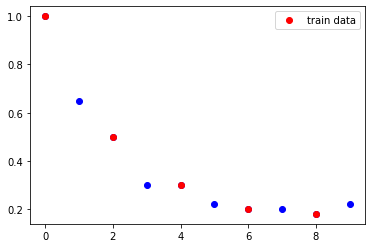

In [ ]:
# リストからDataFrameを作成
x = range(0,10)
y = [1, 0.65, 0.5, 0.3, 0.3, 0.22, 0.2, 0.2, 0.18, 0.22]
dataset = pd.DataFrame(list(zip(x, y)), columns=['x', 'y'])

# 偶数行のデータを学習データとする
train_idx = [c for c in dataset.index if c%2==0]
train = dataset.iloc[train_idx]

# 評価データと学習データを定義
x_all = dataset['x'].to_numpy()
y_all = dataset['y'].to_numpy()
x_train = train['x'].to_numpy()
y_train = train['y'].to_numpy()

# 可視化
def plt_dataset(x_all, y_all, x_train, y_train):
    plt.plot(x_all, y_all, 'bo')
    plt.plot(x_train, y_train, 'ro', label='train data')
plt_dataset(x_all, y_all, x_train, y_train)
plt.legend()
plt.show()

### モデル定義

In [ ]:
class curve_fit_model:
    def __init__(self):
        self.func = 'func'
        self.params = []
        self.popt = []
    def set_func(self, func, num_params):
        '''y=f(x)の形式の関数とパラメータ数を受け取って関数を定義する'''
        self.func = func
        self.params = [1]*num_params # 初期値が全て1のパラメータリストを作成
    def fit(self, x, y):
        '''xとyを受け取ってフィッティングさせる。係数が出力される'''
        popt, pcov = curve_fit(self.func, x, y, p0=self.params) # フィッティング
        coefs =[print(f'coef{i+1}: {j}') for i, j in enumerate(popt)] # 係数を出力
        self.popt = popt # 係数が入ったリスト
    def pred(self, x):
        '''xを受け取ってyを計算する'''
        y = self.func(x, *self.popt)
        return y

### フィッティング関数の定義

In [ ]:
def xn(x, *params): 
    '''多項式近似'''
    y = sum(param*x**n for (n, param) in enumerate(params))
    return y

def exp(x, *params):
    '''指数関数的減衰'''
    y = params[0]*np.exp(-x/params[1])
    return y

### 学習結果を可視化

多項式近似
coef1: 0.9974285708338295
coef2: -0.32726190298037394
coef3: 0.04642857083542192
coef4: -0.0022916666184913644
MSE: 0.16%


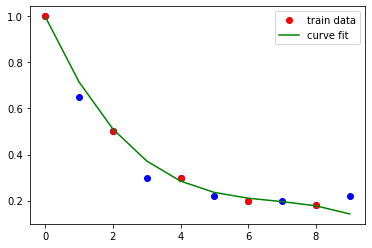

指数関数的減衰
coef1: 0.9741548704190531
coef2: 3.5651483462986224
MSE: 0.57%


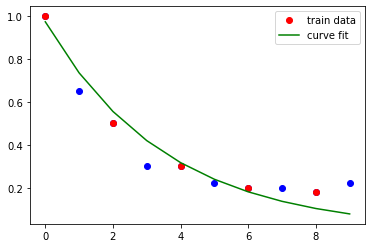

In [ ]:
func_list = [
    {'func': xn, 'num_params': 4},
    {'func': exp, 'num_params': 2},
]

for func in func_list:
    # モデル学習
    print(func['func'].__doc__)
    model = curve_fit_model()
    model.set_func(**func)
    model.fit(x_train, y_train)
    y_pred = model.pred(x_all)
    # MSEを計算
    print(f'MSE: {mean_squared_error(y_all, y_pred):.2%}')
    # 予測と可視化
    plt_dataset(x_all, y_all, x_train, y_train)
    plt.plot(x_all, y_pred, 'g', label='curve fit')
    plt.legend()
    plt.show()

---
## 便利な自作関数
> スクリプトの最初の方に定義しておくと便利

### DataFrameの行ごとに関数を適用する
> 関数を2段階に分けて書くことで処理がわかりやすくなり、コードが再利用しやすくなる

In [ ]:
def profit_ratio(price, cost):
    '''2つの値を受け取って利益率を計算する
    '''
    return (price - cost) / price

def func_to_cols(row, func, columns):
    '''dfの行の特定カラムの値に対して関数を適用する
    戻り値を*valuesとすることで、リストの中身が展開（アンパック）されて関数に渡される
    valuesの長さが合っていればfuncは3個以上の引数を引数を取れる
    '''
    values = [row[c] for c in columns]
    return func(*values)

# applyはデフォルトだと1つの引数しか受け取らないのでargsで関数名とカラム名を与える
columns = ['unit_price', 'unit_cost']
product['profit_ratio'] = product.apply(func_to_cols, args=[profit_ratio, columns], axis=1)
product.head()

,product_cd,category_major_cd,category_medium_cd,category_small_cd,unit_price,unit_cost,profit_ratio
0,P040101001,04,0401,040101,198.0,149.0,0.247475
1,P040101002,04,0401,040101,218.0,164.0,0.247706
2,P040101003,04,0401,040101,230.0,173.0,0.247826
3,P040101004,04,0401,040101,248.0,186.0,0.250000
4,P040101005,04,0401,040101,268.0,201.0,0.250000


### 形式の同じCSVデータを読み込んで縦方向に結合する関数

In [ ]:
# for文の中でpd.concat()するよりもまとめてconcatした方が速い
def get_concat_df(folder_path, sep='*.csv'):
    df_list = []
    file_list = glob.glob(os.path.join(folder_path, sep))
    for file_path in file_list:
        df_list.append(pd.read_csv(file_path))
    df = pd.concat(df_list)
    return df

---
## その他の小ネタ

### 関数やメソッドに何度も書くキーワード引数を辞書型で渡す
> to_csv()でファイルをいくつも出力するときに便利

In [ ]:
kwds = {'index': False, 'sep': ','}
category.head().to_clipboard(**kwds) # index=False, sep=','と書いたのと同様になる

### DataFrameをクリップボードでやりとりする
> indexが不要な場合はindex=Falseとする

In [ ]:
# DataFrameの内容をクリップボードにコピーして、Excelなどに貼り付けられるようにする。
category.head().to_clipboard()
# クリップボードの中身を確認
print(pyperclip.paste())
# クリップボードからdfを作ることもできる
display(pd.read_clipboard())

# 引数sepを使うと、csv形式にもできる
category.head().to_clipboard(sep=',')
print(pyperclip.paste())

	category_major_cd	category_major_name	category_medium_cd	category_medium_name	category_small_cd	category_small_name
0	04	惣菜	0401	御飯類	040101	弁当類
1	04	惣菜	0401	御飯類	040102	寿司類
2	04	惣菜	0402	佃煮類	040201	魚介佃煮類
3	04	惣菜	0402	佃煮類	040202	海草佃煮類
4	04	惣菜	0402	佃煮類	040203	野菜佃煮類



,category_major_cd,category_major_name,category_medium_cd,category_medium_name,category_small_cd,category_small_name
0,4,惣菜,401,御飯類,40101,弁当類
1,4,惣菜,401,御飯類,40102,寿司類
2,4,惣菜,402,佃煮類,40201,魚介佃煮類
3,4,惣菜,402,佃煮類,40202,海草佃煮類
4,4,惣菜,402,佃煮類,40203,野菜佃煮類


,category_major_cd,category_major_name,category_medium_cd,category_medium_name,category_small_cd,category_small_name
0,04,惣菜,0401,御飯類,040101,弁当類
1,04,惣菜,0401,御飯類,040102,寿司類
2,04,惣菜,0402,佃煮類,040201,魚介佃煮類
3,04,惣菜,0402,佃煮類,040202,海草佃煮類
4,04,惣菜,0402,佃煮類,040203,野菜佃煮類



### DataFrameの特定行の列名と値をいい感じに表示する
> カラム名に日本語が入っていると崩れるので工夫が必要

In [ ]:
# 表示する行
row = 0 
# ここにカラム名と値を入れていく
text = [] 
# 文字を整形するため、文字数の最大値を取得
max_len = max([len(x) for x in category.columns.to_list()])
# 表示するテキスト作成
for k, v in category.iloc[row].to_dict().items():
    k, v = str(k), str(v)
    text += [f'{k.ljust(max_len+1)}: {v}']
text = ('\n').join(text)
print(text)

category_major_cd    : 04
category_major_name  : 惣菜
category_medium_cd   : 0401
category_medium_name : 御飯類
category_small_cd    : 040101
category_small_name  : 弁当類


### カラムごとの集計値をdfの形にする
> desicribe()で集計されないものもdfの形式で表示できる

In [ ]:
category.nunique().reset_index(name='nunique')

,index,nunique
0,category_major_cd,6
1,category_major_name,6
2,category_medium_cd,57
3,category_medium_name,56
4,category_small_cd,228
5,category_small_name,219
